# Which Teams are Failing to Meet Expectations?

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import datetime
from scipy.constants import golden

from PIL import Image
import urllib
import json
import os

In [18]:
font_path = "./assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("./assets/stylesheets/soc_base.mplstyle")

## I Dati

In [19]:
df = pd.read_csv("data/FiveThirtyEight/soccer-spi/07-06/spi_matches.csv", sep=",", decimal=".")
df = df[(df.league=='Italy Serie A') & (df.season >= 2022) ]

In [20]:
def compute_points(x,y):
    '''
    This function computed the points achieved by each side.
    '''
    if x > y:
        return 3
    if x == y:
        return 1
    else:
        return 0

In [21]:
df['xpoints1'] = df['prob1']*3 + df['probtie']
df['xpoints2'] = df['prob2']*3 + df['probtie']
df['points1'] = [compute_points(x,y) for x,y in zip(df['score1'], df['score2'])]
df['points2'] = [compute_points(y,x) for x,y in zip(df['score1'], df['score2'])]
df

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,xpoints1,xpoints2,points1,points2
56894,2022,2022-08-13,1854,Italy Serie A,Sampdoria,Atalanta,52.95,73.01,0.2101,0.5546,...,0.56,2.01,1.40,1.21,0.00,1.58,0.8656,1.8991,0,3
56896,2022,2022-08-13,1854,Italy Serie A,AC Milan,Udinese,78.31,57.94,0.6751,0.1206,...,2.53,0.48,0.99,1.30,4.20,2.10,2.2296,0.5661,3,0
56921,2022,2022-08-13,1854,Italy Serie A,Lecce,Internazionale,50.41,82.17,0.1144,0.6995,...,0.64,2.43,0.70,2.38,1.05,2.10,0.5292,2.2845,0,3
56923,2022,2022-08-13,1854,Italy Serie A,Monza,Torino,52.84,62.83,0.3254,0.3833,...,1.15,2.29,0.84,0.79,1.05,2.10,1.2675,1.4412,0,3
57017,2022,2022-08-14,1854,Italy Serie A,Lazio,Bologna,69.72,56.11,0.5987,0.1771,...,0.83,1.59,0.98,0.58,2.10,0.84,2.0203,0.7555,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67404,2022,2023-06-04,1854,Italy Serie A,Lecce,Bologna,59.79,63.89,0.3535,0.3436,...,1.30,0.85,1.19,0.67,2.10,3.15,1.3634,1.3337,0,3
67405,2022,2023-06-04,1854,Italy Serie A,AC Milan,Verona,73.33,50.40,0.6617,0.1201,...,2.01,0.84,1.91,0.53,2.63,1.05,2.2033,0.5785,3,0
67406,2022,2023-06-04,1854,Italy Serie A,Udinese,Juventus,60.57,69.73,0.2447,0.4924,...,0.84,1.62,1.19,2.61,0.00,1.05,0.9970,1.7401,0,3
67408,2022,2023-06-04,1854,Italy Serie A,Atalanta,Monza,69.91,60.35,0.4484,0.2939,...,2.80,1.41,2.55,0.88,4.32,2.10,1.6029,1.1394,3,0


In [22]:
df_team1 = df[['team1', 'xpoints1', 'points1']]
df_team2 = df[['team2', 'xpoints2', 'points2']]
df_team1.columns = ['team', 'xpoints', 'points']
df_team2.columns = ['team', 'xpoints', 'points']
df_g = (
    pd.concat([df_team1, df_team2])
    .groupby(['team']).sum()
    .reset_index()
    .assign(difference = lambda x: x.points - x.xpoints)
)
df_g

,team,xpoints,points,difference
0,AC Milan,71.9525,70,-1.9525
1,AS Roma,67.8668,63,-4.8668
2,Atalanta,63.8890,64,0.1110
3,Bologna,44.7587,54,9.2413
4,Cremonese,36.1622,27,-9.1622
5,Empoli,37.9556,43,5.0444
6,Fiorentina,58.9647,56,-2.9647
7,Internazionale,76.1422,72,-4.1422
8,Juventus,63.6833,72,8.3167
9,Lazio,60.4874,74,13.5126


Per i loghi abbiamo bisogno degli ID della squadra dal sito https://images.fotmob.com

In [23]:

team_map = {
    'team': [
        "Napoli",
        "Lazio",
        "Juventus",
        "Internazionale",
        "Atalanta",
        "AC Milan",
        "AS Roma",
        "Fiorentina",
        "Bologna",
        "Monza",
        "Torino",
        "Sassuolo",
        "Udinese",
        "Salernitana",
        "Empoli",
        "Lecce",
        "Verona",
        "Spezia",
        "Cremonese",
        "Sampdoria"
    ],
    'fotmob_id':[
        9875,
        8543,
        9885,
        8636,
        8524,
        8564,
        8686,
        8535,
        9857,
        6504,
        9804,
        7943,
        8600,
        6480,
        8534,
        9888,
        9876,
        9881,
        7801,
        9882
    ],
}

team_map = pd.DataFrame(team_map)
team_map

,team,fotmob_id
0,Napoli,9875
1,Lazio,8543
2,Juventus,9885
3,Internazionale,8636
4,Atalanta,8524
5,AC Milan,8564
6,AS Roma,8686
7,Fiorentina,8535
8,Bologna,9857
9,Monza,6504


In [24]:
df_g = pd.merge(df_g, team_map)
df_g = df_g.sort_values(by="points", ascending=False)
df_g

,team,xpoints,points,difference,fotmob_id
12,Napoli,75.5929,90,14.4071,9875
9,Lazio,60.4874,74,13.5126,8543
7,Internazionale,76.1422,72,-4.1422,8636
8,Juventus,63.6833,72,8.3167,9885
0,AC Milan,71.9525,70,-1.9525,8564
2,Atalanta,63.8890,64,0.1110,8524
1,AS Roma,67.8668,63,-4.8668,8686
6,Fiorentina,58.9647,56,-2.9647,8535
3,Bologna,44.7587,54,9.2413,9857
17,Torino,49.8813,53,3.1187,9804


Funzione che genera i punti cumulativi data la squadra

In [25]:
def get_cumpoints_df(team, data = df):

    df = data.copy()
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    is_in_home = df[(df['team1'] == team)][['team1', 'points1', 'xpoints1', 'date']].reset_index(drop=True)
    is_in_away = df[(df['team2'] == team)][['team2', 'points2', 'xpoints2', 'date']].reset_index(drop=True)
    is_in_home.columns = ['team', 'points', 'xpoints', 'date']
    is_in_away.columns = ['team', 'points', 'xpoints', 'date']
    df = pd.concat([is_in_home, is_in_away]).sort_values(by='date', ascending=True).reset_index(drop=True)
    df['cum_points'] = df['points'].cumsum()
    df['cum_xpoints'] = df['xpoints'].cumsum()
    return df

# Check to see if it works
get_cumpoints_df('Napoli')

,team,points,xpoints,date,cum_points,cum_xpoints
0,Napoli,3,1.7358,2022-08-15,3,1.7358
1,Napoli,3,2.3339,2022-08-21,6,4.0697
2,Napoli,1,1.5974,2022-08-28,7,5.6671
3,Napoli,1,2.4032,2022-08-31,8,8.0703
4,Napoli,3,1.4886,2022-09-03,11,9.5589
5,Napoli,3,2.5022,2022-09-10,14,12.0611
6,Napoli,3,1.2881,2022-09-18,17,13.3492
7,Napoli,3,2.1956,2022-10-01,20,15.5448
8,Napoli,3,2.3103,2022-10-09,23,17.8551
9,Napoli,3,2.5265,2022-10-16,26,20.3816


## The Visual

In [26]:
xpts_color = '#1F1B8E'
pts_color = '#D49208'
upp_diff = '#1A85FF'
low_diff = '#9C0404'

In [27]:
def diff_color(difference):
    if difference > 2.5:
        return upp_diff
    elif difference < -0.5:
        return low_diff
    return '#000000'

In [28]:
selector = [x % 2 == 0 for x in range(0, 38)]
def plot_point_difference(ax, team, label_y = False, data=df):
    ax.grid(ls='--', color='lightgrey')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linestyle('dashed')
    ax.tick_params(color='lightgrey', labelsize=8, labelcolor='grey')
    test_df = get_cumpoints_df(team, data)[selector]
    ax.spines['bottom'].set_visible(False)

    ax.plot(test_df.index + 1, test_df['cum_points'], marker='o', mfc='white', ms=4, color=pts_color, zorder=4)
    ax.plot(test_df.index + 1, test_df['cum_xpoints'], marker='o', mfc='white', ms=4, color=xpts_color, zorder=4)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.set_ylim(-2,90)
    ax.set_xlim(0, 39)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    #ax.set_xticklabels([])
    mid_point = test_df['cum_points'].iloc[-1] + (test_df['cum_xpoints'].iloc[-1] - test_df['cum_points'].iloc[-1])/2
    difference = test_df['cum_points'].iloc[-1] - test_df['cum_xpoints'].iloc[-1]
    
    
    if label_y:
        ax.set_ylabel('Points', color='grey', size=8)
    else:
        ax.set_yticklabels([])
    return

In [29]:
def multiplot(nrows, ncols, data = df_g, off=1):
    fig = plt.figure(figsize=(16, 9), dpi = 200)
    gspec = gridspec.GridSpec(
        ncols=ncols, nrows=nrows, figure=fig, 
        height_ratios = [(1/nrows)*2.6 if x % 2 != 0 else (1/nrows)/2.6 for x in range(nrows)], 
        hspace=0.4,
    )



    plot_counter = 0
    logo_counter = 0
    for row in range(nrows):
        for col in range(ncols):
            if row % 2 != 0:
                ax = plt.subplot(
                    gspec[row, col],
                    facecolor = "#EFE9E6"
                )
                team = data['team'].iloc[plot_counter]
                if col == 0:
                    label_y = True
                else:
                    label_y = False

                plot_point_difference(ax, team, label_y)           
                plot_counter += 1
            else:
                teamId = data['fotmob_id'].iloc[logo_counter]
                teamName = data['team'].iloc[logo_counter]
                xpoints = data['xpoints'].iloc[logo_counter]
                apoints = data['points'].iloc[logo_counter]
                fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
                logo_ax = plt.subplot(
                    gspec[row,col],
                    anchor = 'NW', facecolor = '#EFE9E6'
                )
                club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{teamId:.0f}.png')).convert('RGBA')
                logo_ax.imshow(club_icon)
                logo_ax.axis('off')
                # -- Add the team name
                diff = data.difference.iloc[logo_counter]
                ax_text(
                    x = 1.2, 
                    y = 0.9,
                    s = f'<{teamName} (#{logo_counter+off})>\n<xPunti: {xpoints:.1f}> <|> <Punti Effettivi: {apoints:.0f}> <|> <Differenza:> <{diff:.1f}>',
                    ax = logo_ax, 
                    highlight_textprops=[{'weight':'bold', 'font':'DM Sans'},{'size':'7', 'color': xpts_color}, {'size':'7', 'color': 'grey'}, {'size':'7', 'color': pts_color}, {'size':'7', 'color': 'grey'}, {'size':'7', 'color': 'grey'}, {'size':'7', 'color': diff_color(diff)},],
                    font = 'Karla', 
                    ha = 'left', 
                    size = 12,
                    vsep=2,
                    weight='bold',
                    annotationbbox_kw = {'xycoords':'axes fraction'}
                )
                logo_counter += 1

    return

'\nplt.savefig(\n    "../Grafici/figures/PTS-xPTS_12_tr.png",\n    dpi = 600,\n    facecolor = "none",\n    bbox_inches="tight",\n    edgecolor="none",\n    transparent = True\n)'

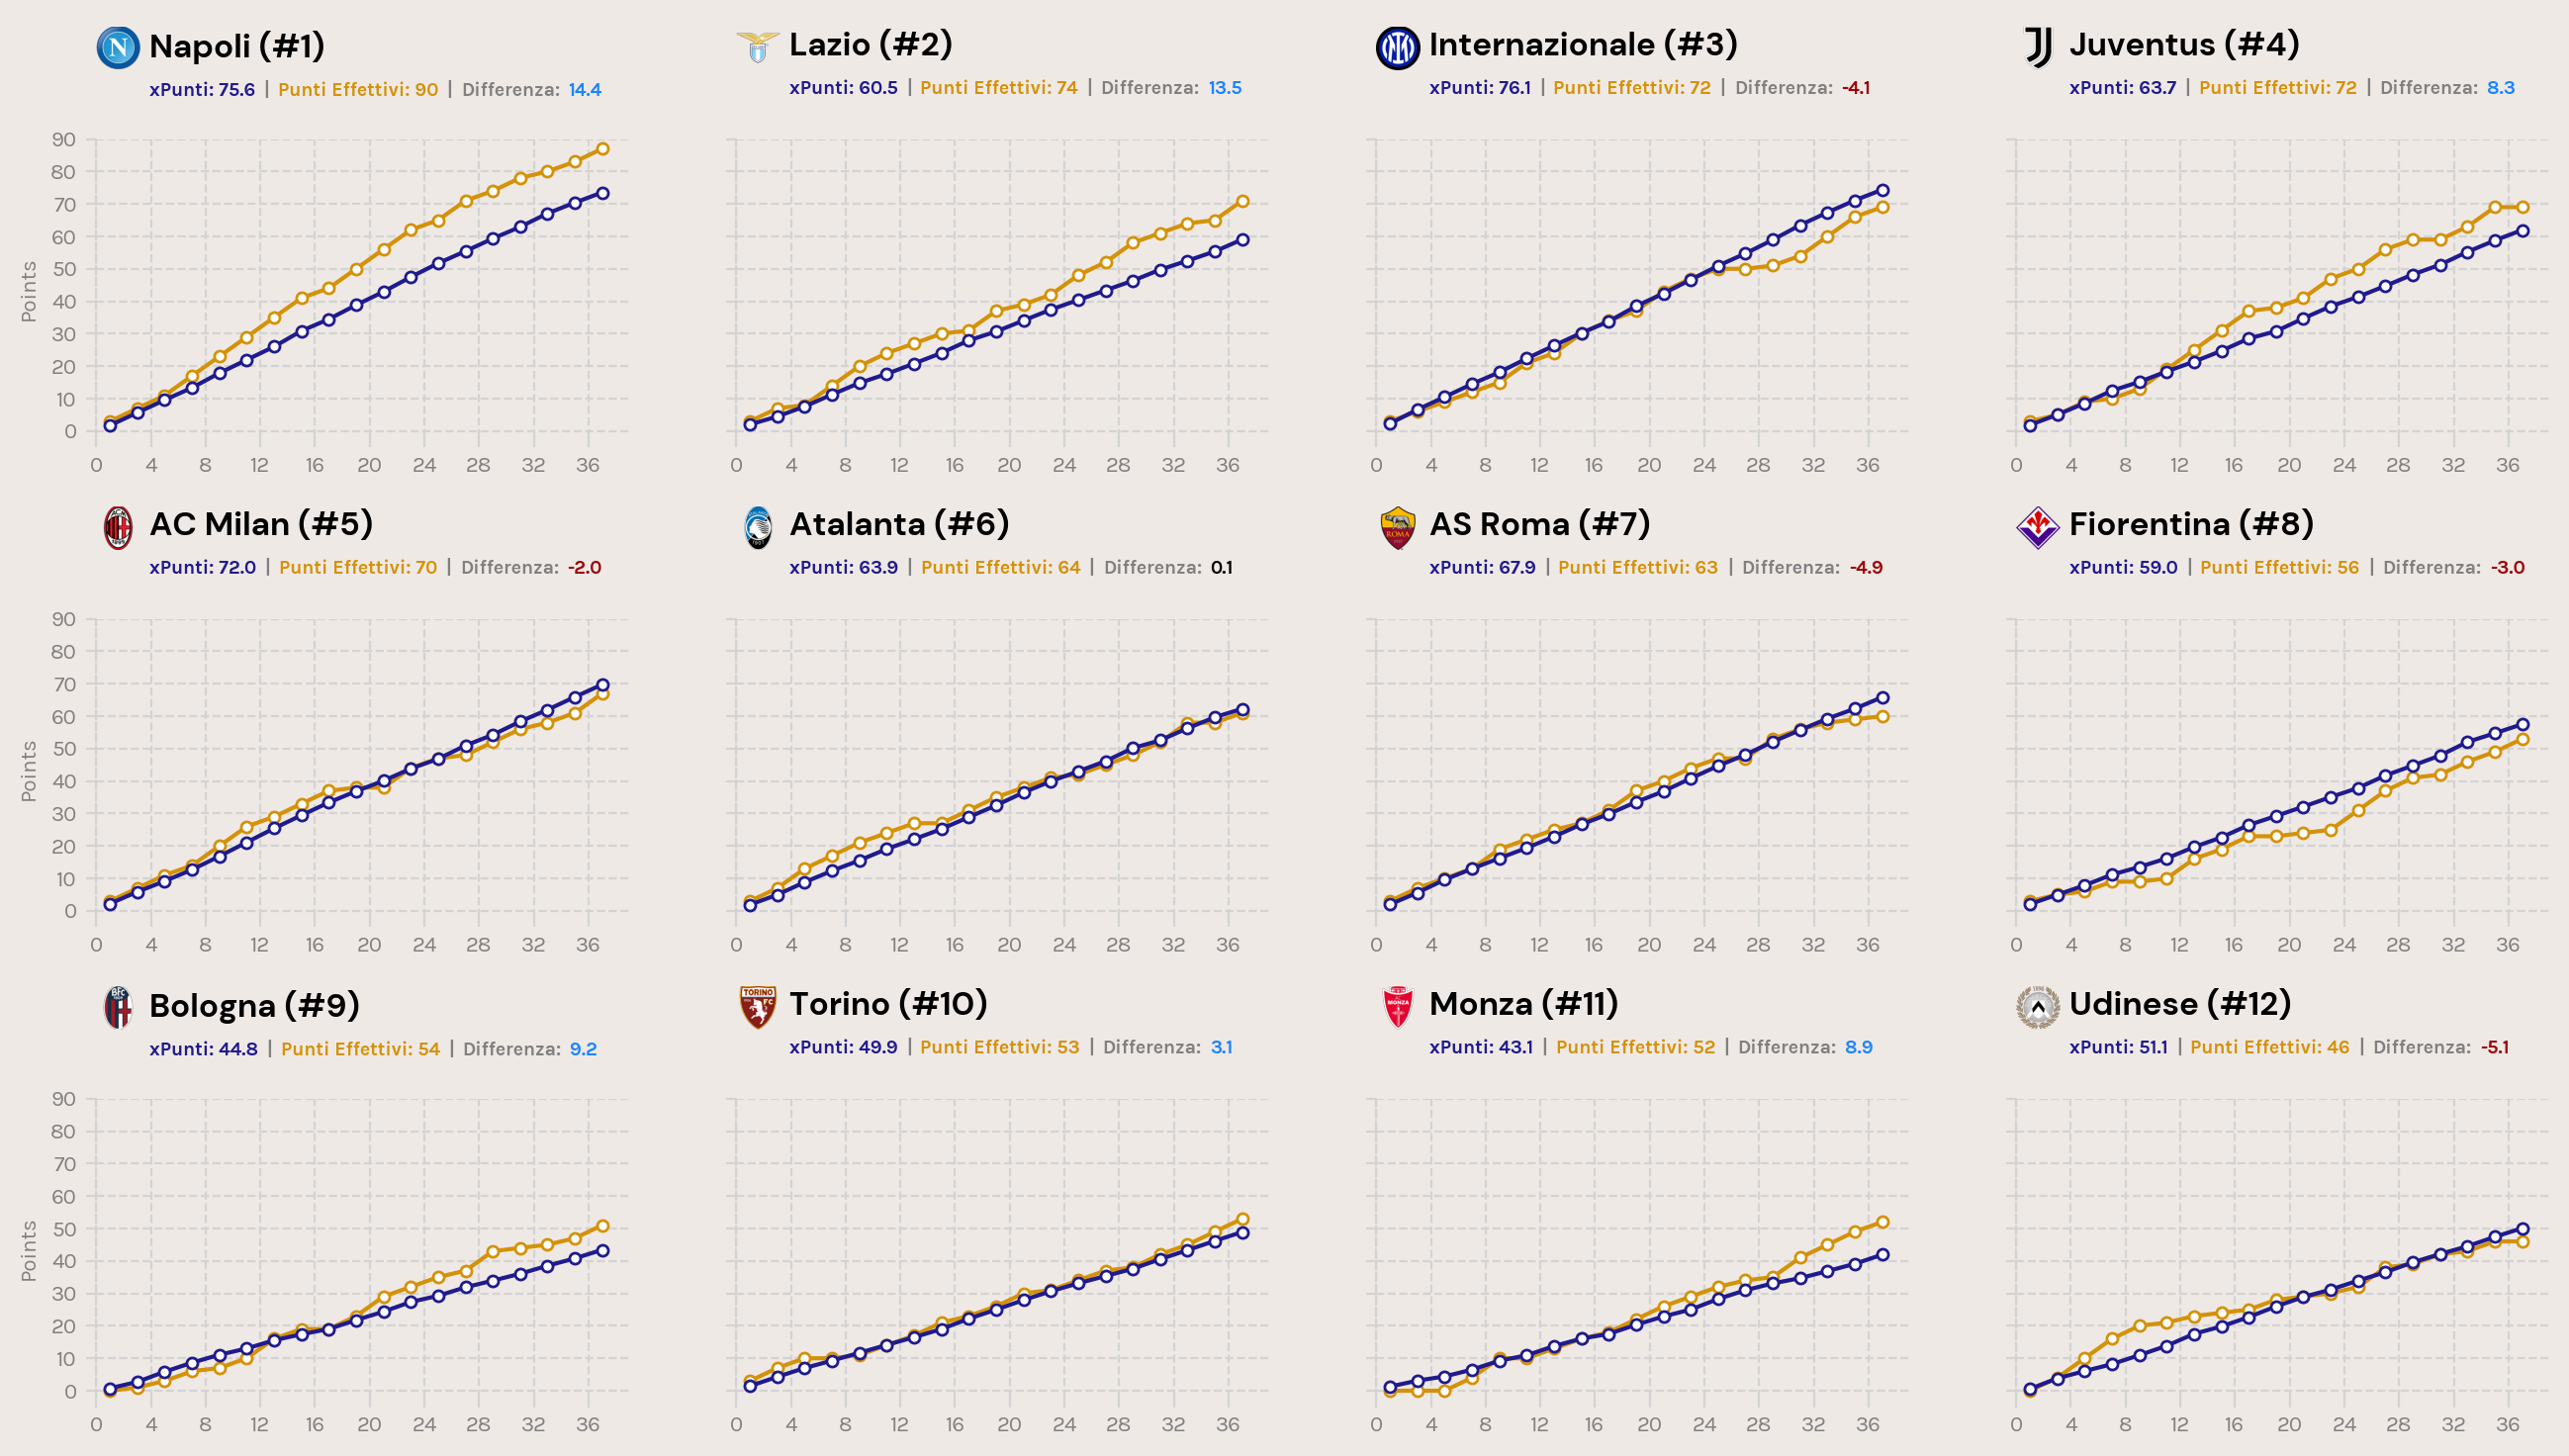

In [30]:
multiplot(6, 4, df_g[:13])
plt.savefig(
    "../Grafici/figures/PTS-xPTS_12.png",
    dpi = 600,
    facecolor = "#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent = False
)

'''
plt.savefig(
    "../Grafici/figures/PTS-xPTS_12_tr.png",
    dpi = 600,
    facecolor = "none",
    bbox_inches="tight",
    edgecolor="none",
    transparent = True
)'''

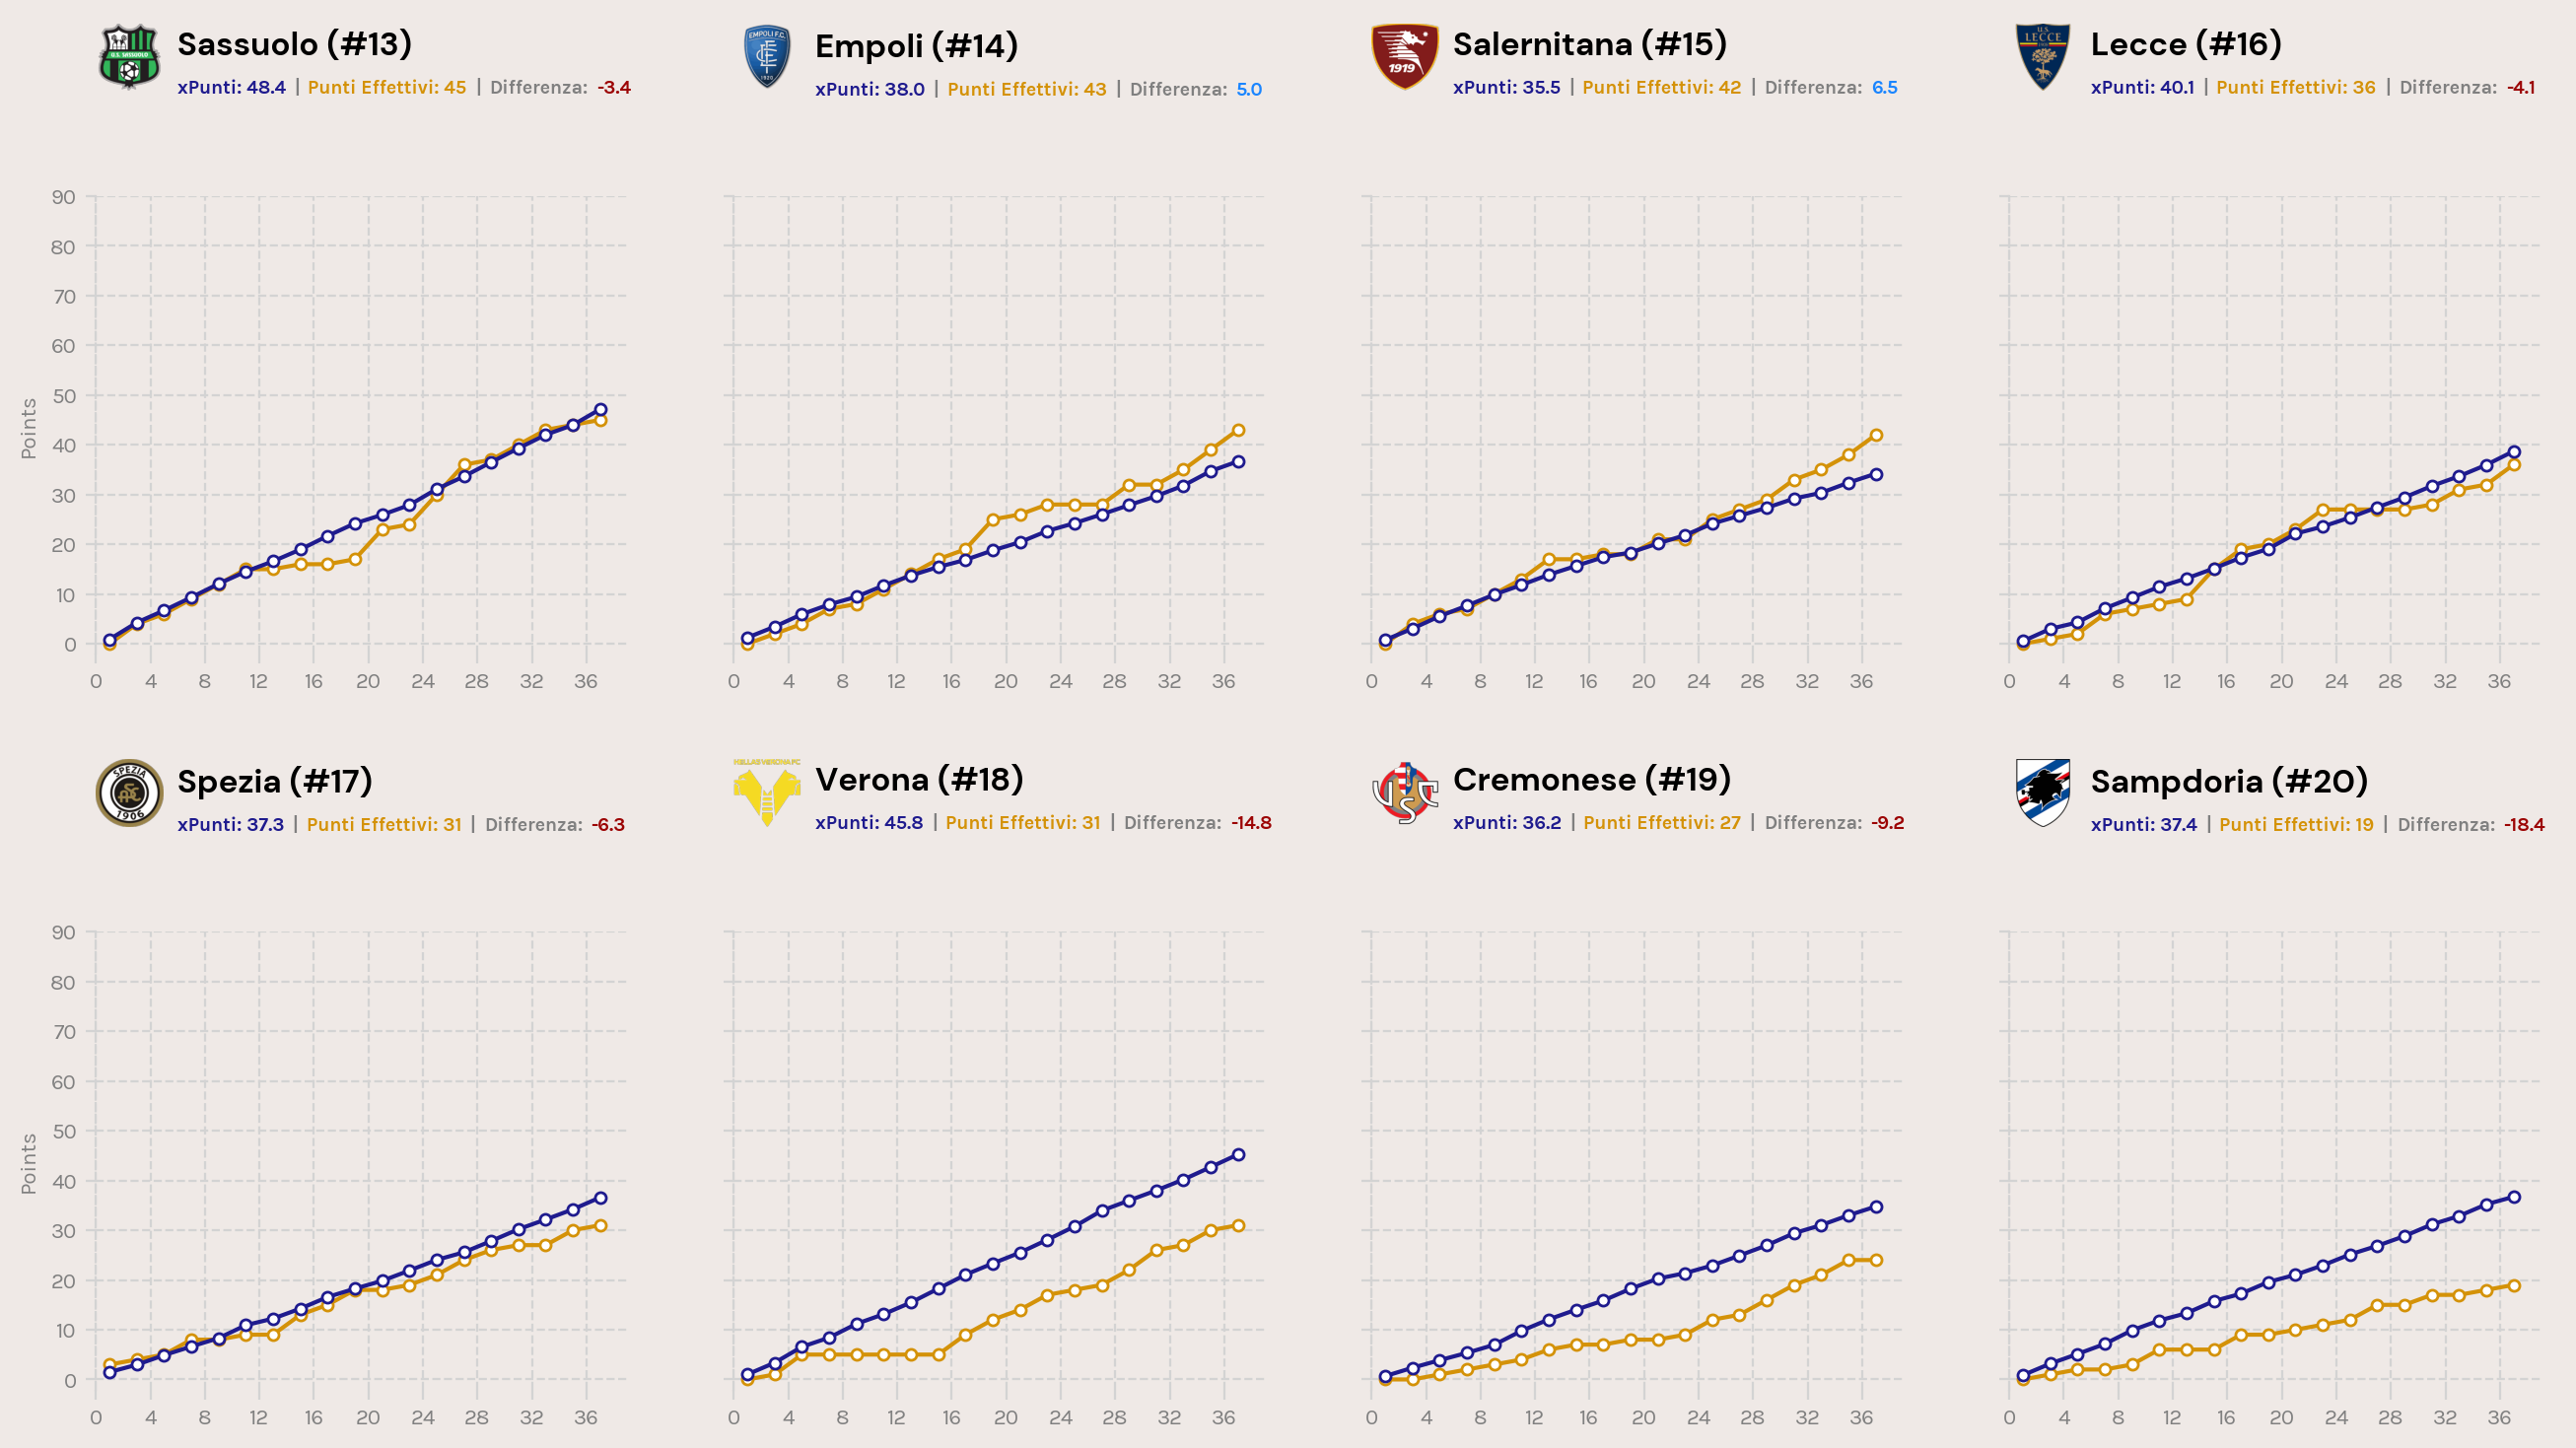

In [31]:
multiplot(4, 4, df_g[12:], off=13)
plt.savefig(
    "./figures/PTS-xPTS_8.png",
    dpi = 600,
    facecolor = "#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent = False
)

plt.savefig(
    "./figures/PTS-xPTS_8_tr.png",
    dpi = 600,
    facecolor = "none",
    bbox_inches="tight",
    edgecolor="none",
    transparent = True
)